## CLASSIFICATION: UNCLASSIFIED

## 2D Convolution Network Example with Image Data

The techniques

We illustrate two techniques for images classification in this short notebook, namely:

* 2D convolutional networks for the classification model, and
* generating noisy images to augment the training set. 

Thw 2D convolutional network models is very successful for object recognition, as it is able to preserve the spatial structure of the problem. They typically use fewer parameters than fully connected nets, and are designed to be invariant to object position or distortion. There are 3 building blocks (layer types) in CNNs:

* convolutional: which consist of filters over square patches (2D) or strings (1D), and feature maps, which is the output of the filter drawn across the entire previous layer;
* pooling: which down-sample the previous layer feature map, and
* fully connected: as in feed-forward neural nets.

### The Data

We look at a subset of images from the CIFAR-10 dataset, namely all images with either ''birds'' or ''planes''.
We build a classification model to distinguish those two categories, which we encode as birds = 1 (positive class) and planes = 0 (negative class). There are 10000 training images and 2000 test images, all of size 32x32 over 3 channels (RGB). The classes are perfectly balanced.


In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

import pickle
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)


### Load the data

The data is saved in a pickle file, already divided up as training and test sets.
We also define a utility function to plot some images. 


In [2]:
## load the pickle file with the data already divided as train/test sets
import get_data
get_data.get_file("birds.pkl", "../data/")
with open('../data/birds.pkl','rb') as infile:
    (X_train, Y_train) , (X_test, Y_test) = pickle.load(infile)
print(X_train.shape , X_test.shape)


(10000, 32, 32, 3) (2000, 32, 32, 3)


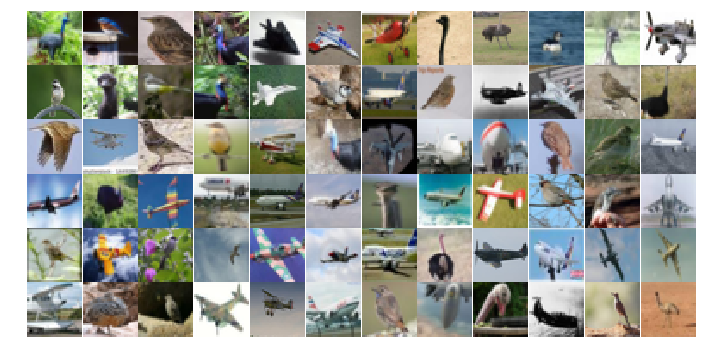

In [3]:
## function to plot an array of images
def plotImgs(X, hor=6, ver=3):
    fig, axs = plt.subplots(ver,hor,figsize=(hor,ver))
    fig.subplots_adjust(hspace=0, wspace=0)
    axs = axs.ravel()
    for i in range(hor*ver):
        plt.axis('off')
        im = np.reshape(X[i], (32,32,3), order='F')
        axs[i].imshow(im.transpose(1,0,2))
        axs[i].axis('off')
## Make sure the images look ok (should be birds and planes)
plotImgs(X_train,12,6)


### Build the 2D ConvNet

* Conv2D: specifies a conolution layer (filters), here over 3x3 boxes
* MaxPooling2D: perform down-sampling
* Flatten: is used to feed into dense layer(s)
* Dense: are as in feed-forward neural nets
* Dropout: are used to avoid over-fitting

For the activation function, ''relu'' (rectified linear units) are most commonly used; for the last layer, we use a ''softmax'' to output a value in the [0,1] range which we will use as a probability on the test sample, Pr(image is a bird).


In [4]:
## build a 2D CNN 
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(32,32,3), activation='relu',  data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_last' ))
model.add(Conv2D(64,(3,3), activation='relu',  data_format='channels_last'))
model.add(Conv2D(64,(3,3), activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               819712    
__________

### Compile and fit to training data

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=3, batch_size=100, verbose=0, validation_data=(X_test,Y_test), shuffle=True);


### Apply to test data

Get the prediction from the model applied to the test data, which we use as probability that each image represents a bird. We also compute and print the confusion matrix over the test data, assuming a threshold at 0., i.e. we predict a bird if the score is 0.5 or more, and a plane otherwise.


In [6]:
## get predictions over test data
bird_score = model.predict(X_test)[:,1]
## print confusion matrix over test data, compute accuracy
R = pd.DataFrame({'pred':[x >= .5 for x in bird_score], 'real':[x[1] == 1 for x in Y_test]})
Z = R.groupby(["real","pred"]).size()
print(Z)
print('Accuracy = ', (Z[0,0]+Z[1,1])/X_test.shape[0])

real   pred 
False  False    835
       True     165
True   False     94
       True     906
dtype: int64
Accuracy =  0.8705


### Plotting some test cases ...

* True negatives: planes with low bird score
* True positives: birds with high bird score
* False negatives: birds with low bird score
* False positives: planes with high bird score


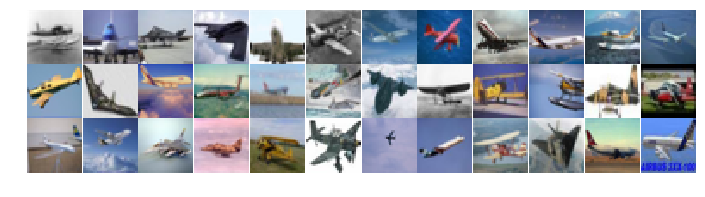

In [7]:
## True Negatives: planes with score < .5
idx = np.where(np.logical_and(Y_test[:,1] == 0 , bird_score < .5))[0]
np.random.shuffle(idx)
plotImgs(X_test[idx], 12, 3)


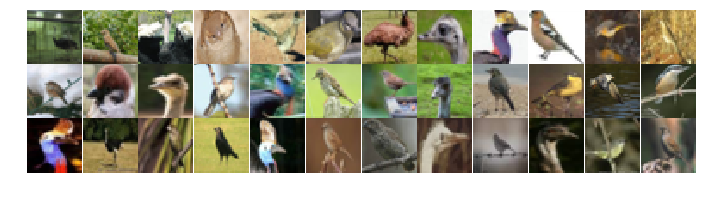

In [8]:
## True Positives: birds with score > .5
idx = np.where(np.logical_and(Y_test[:,1] == 1 , bird_score > .5))[0]
np.random.shuffle(idx)
plotImgs(X_test[idx], 12, 3)


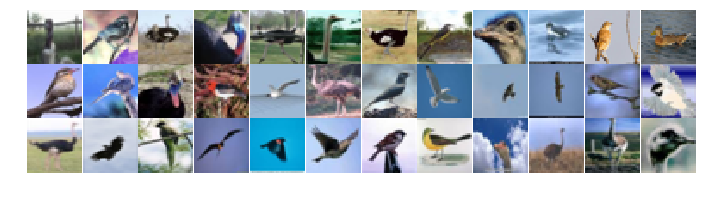

In [9]:
## False Negatives: birds with score < .5
idx = np.where(np.logical_and(Y_test[:,1] == 1 , bird_score < .5))[0]
np.random.shuffle(idx)
plotImgs(X_test[idx], 12, 3)


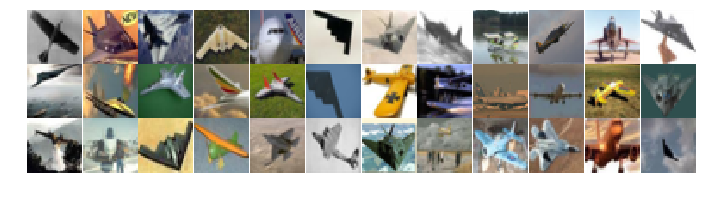

In [10]:
## False Positives: planes with score > .5
idx = np.where(np.logical_and(Y_test[:,1] == 0 , bird_score > .5))[0]
np.random.shuffle(idx)
plotImgs(X_test[idx], 12, 3)


## Comparing with a FFNN

ConvNets are specially designed for image identification. How would a simple feed-forward neural net do with such a task? 

In [11]:
## try a Feed Forward
ffnn = Sequential()
ffnn.add(Flatten(input_shape=(32,32,3)))
ffnn.add(Dense(512, activation='relu'))
ffnn.add(Dropout(0.5))
ffnn.add(Dense(512, activation='relu'))
ffnn.add(Dropout(0.5))
ffnn.add(Dense(2))
ffnn.add(Activation('softmax'))
ffnn.summary()
ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ffnn.fit(X_train, Y_train, epochs=5, batch_size=100, verbose=0, validation_data=(X_test,Y_test), shuffle=True);


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total para

### Results

The confusion matrix shows a higher error rate than with a CNN.
Moreover, looking at the false/true positives/negatives below, the model
seems to capture mainly features such as the background color.

In [12]:
## confusion matrix
ffnn_bird_score = ffnn.predict(X_test)[:,1]
R = pd.DataFrame({'pred':[x >= .5 for x in ffnn_bird_score], 'real':[x[1] == 1 for x in Y_test]})
Z = R.groupby(["real","pred"]).size()
print(Z)
print('Accuracy = ', (Z[0,0]+Z[1,1])/X_test.shape[0])

real   pred 
False  False    765
       True     235
True   False    197
       True     803
dtype: int64
Accuracy =  0.784


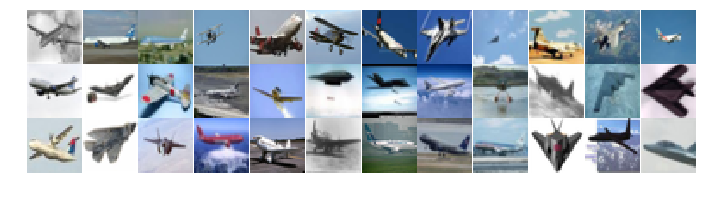

In [13]:
## True Negatives: planes with score < .5
idx = np.where(np.logical_and(Y_test[:,1] == 0 , ffnn_bird_score < .5))[0]
np.random.shuffle(idx)
plotImgs(X_test[idx], 12, 3)


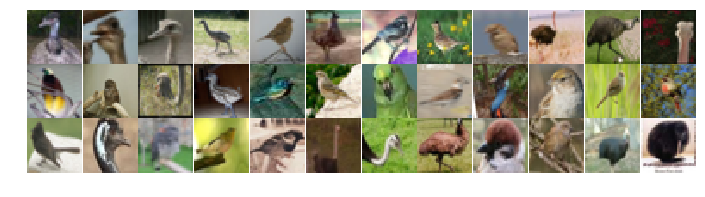

In [14]:
## True Positives: birds with score > .5
idx = np.where(np.logical_and(Y_test[:,1] == 1 , ffnn_bird_score > .5))[0]
np.random.shuffle(idx)
plotImgs(X_test[idx], 12, 3)


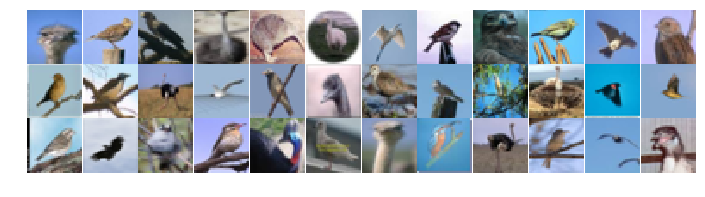

In [15]:
## False Negatives: birds with score < .5
idx = np.where(np.logical_and(Y_test[:,1] == 1 , ffnn_bird_score < .5))[0]
np.random.shuffle(idx)
plotImgs(X_test[idx], 12, 3)


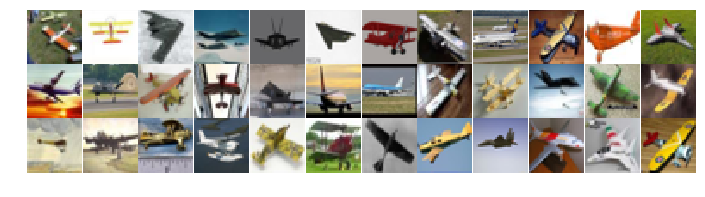

In [16]:
## False Positives: planes with score > .5
idx = np.where(np.logical_and(Y_test[:,1] == 0 , ffnn_bird_score > .5))[0]
np.random.shuffle(idx)
plotImgs(X_test[idx], 12, 3)


## Data Augmentation

One possible way to improve image classification models is to augment the training data by applying various image transformation techniques such as:

* noising
* rotations
* shifts
* flips

In the cells below, we re-train the same CNN, this time adding 5000 new training images obtained via random rotations and shifts of the original training set. We obtain a slighlty better accuracy.


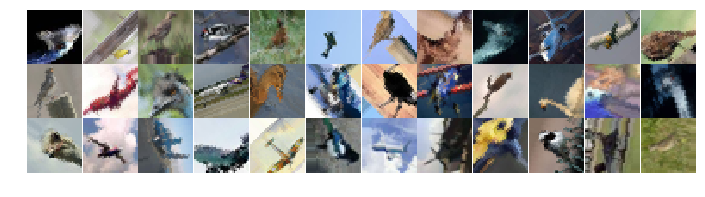

In [17]:
## generate rotated/shifted images, plot a few
datagen = ImageDataGenerator(rotation_range=90, width_shift_range=.1, height_shift_range=.1,)
datagen.fit(X_train)
for X_rot, Y_rot in datagen.flow(x=X_train, y=Y_train, batch_size=5000):
    break ## flow is random and infinite, need to break it
plotImgs(X_rot,12,3)   


In [18]:
## re-train CNN with augmented training dataset
X_trainPlus = np.append(X_train, X_rot, axis=0)
Y_trainPlus = np.append(Y_train, Y_rot, axis=0)
model.reset_states()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_trainPlus, Y_trainPlus, epochs=3, batch_size=100, verbose=0, validation_data=(X_test,Y_test), 
          shuffle=True);


In [19]:
## get predictions over test data
bird_score = model.predict(X_test)[:,1]
## print confusion matrix over test data
R = pd.DataFrame({'pred':[x >= .5 for x in bird_score], 'real':[x[1] == 1 for x in Y_test]})
Z  = R.groupby(["real","pred"]).size()
print(Z)
print('Accuracy = ', (Z[0,0]+Z[1,1])/X_test.shape[0])

real   pred 
False  False    874
       True     126
True   False    113
       True     887
dtype: int64
Accuracy =  0.8805
